In [321]:
import pandas as pd
import numpy as np
#import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns #for pair-plot

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from sklearn.metrics import roc_auc_score, roc_curve, log_loss, brier_score_loss, confusion_matrix
from sklearn.calibration import calibration_curve

import xgboost as xgb

In [322]:
plt.style.use('seaborn')

In [323]:
def logreg_auc(variables, target, basetable):
    X = basetable[variables]
    y = basetable[target].values.ravel()
    logreg = linear_model.LogisticRegression(solver='lbfgs', max_iter = 300)
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

def logreg_ll(variables, target, basetable):
    X = basetable[variables]
    y = basetable[target].values.ravel()
    logreg = linear_model.LogisticRegression(solver='lbfgs', max_iter = 300)
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    ll = log_loss(y, predictions)
    return(ll)

def next_best(current_variables,candidate_variables, target, basetable):
    best_auc = -1
    best_ll = 100000
    best_variable = None
    for v in candidate_variables:
        #auc_v = logreg_auc(current_variables + [v], target, basetable)
        ll_v = logreg_ll(current_variables + [v], target, basetable)
        #if auc_v >= best_auc:
        #    best_auc = auc_v
        if ll_v <= best_ll:
            best_ll = ll_v
            best_variable = v
    print(best_ll)
    return best_variable

In [324]:
def plot_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    #groups.groupby(target).apply(my_agg)
    pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()
    
    # Plot formatting
    plt.xlabel(variable)
    plt.ylabel("Size", rotation = 0,rotation_mode="anchor", ha = "right" )
    
    # Plot the bars with sizes 
    pig_table["Size"].plot(kind="bar", width = 0.5, color = "lightgray", edgecolor = "none") 
    
    # Plot the incidence line on secondary axis
    pig_table["Incidence"].plot(secondary_y = True)
    
    # Plot formatting
    plt.xticks(np.arange(len(pig_table)), pig_table[variable])
    plt.xlim([-0.5, len(pig_table)-0.5])
    plt.ylabel("Incidence", rotation = 0, rotation_mode="anchor", ha = "left")
    
    # Show the graph
    plt.show()
    

In [325]:
data = pd.read_csv("data/data_002.csv")

In [326]:
data.head()

,Unnamed: 0,YEAR,SERIAL,DUID,PID,MEPSID,PANEL,PSUANN,STRATANN,PSUPLD,...,HEARTATTEV,HEARTCONEV,HYPERTENEV,STROKEAGE,STROKEV,HYPERTENAGE,CHEARTDIAGE,HEARTATTAGE,CHOLHIGHAGE,DIABETICAGE
0,1,2010,1,10007,101,1000710115,15,2,1024,2.0,...,1,1,2,0,1,24,96,96,27,96
1,2,2010,1,10007,102,1000710215,15,2,1024,2.0,...,1,1,1,0,1,96,96,96,96,96
2,3,2010,1,10007,103,1000710315,15,2,1024,2.0,...,0,0,0,0,0,96,96,96,96,96
3,4,2010,1,10007,104,1000710415,15,2,1024,2.0,...,0,0,0,0,0,96,96,96,96,96
4,5,2010,2,10008,101,1000810115,15,1,1021,1.0,...,1,1,1,0,1,96,96,96,96,96


In [327]:
data.dtypes

Unnamed: 0       int64
YEAR             int64
SERIAL           int64
DUID             int64
PID              int64
MEPSID           int64
PANEL            int64
PSUANN           int64
STRATANN         int64
PSUPLD         float64
STRATAPLD      float64
PANELYR          int64
RELYR            int64
PERNUM           int64
PERWEIGHT      float64
SAQWEIGHT      float64
DIABWEIGHT     float64
AGE              int64
SEX              int64
MARSTAT          int64
BIRTHYR          int64
REGIONMEPS       int64
FAMSIZE          int64
RACEA            int64
USBORN           int64
INTERVLANG       int64
EDUCYR         float64
HIDEG          float64
WORKEV           int64
INCTOT         float64
FTOTVAL        float64
POVLEV         float64
FILESTATUS       int64
CANCEREV         int64
CHEARTDIEV       int64
CHOLHIGHEV       int64
DIABETICEV       int64
HEARTATTEV       int64
HEARTCONEV       int64
HYPERTENEV       int64
STROKEAGE        int64
STROKEV          int64
HYPERTENAGE      int64
CHEARTDIAGE

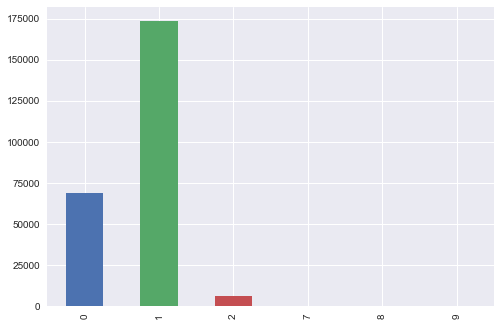

In [328]:
target_variable = "HEARTATTEV"
candidate_variables = []
data[target_variable].value_counts().sort_index().plot("bar");

In [329]:
data[target_variable].isna().sum()

0

In [330]:
#binary classification of target variable
#remove all data rows with unknown target variable
data.drop(data[-data[target_variable].isin([1, 2])].index, inplace = True)
data.loc[data[target_variable] == 1,target_variable] = 0
data.loc[data[target_variable] == 2,target_variable] = 1
data = data.reset_index(drop = True)

In [331]:
data[target_variable].mean()

0.03520315932919876

In [332]:
data["YEAR"].isna().sum()

0

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


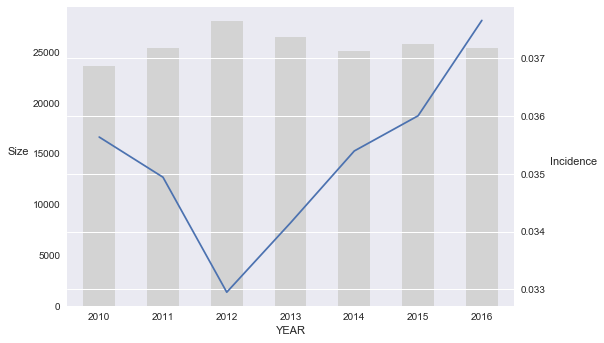

In [333]:
plot_pig_table(data, target_variable, "YEAR")

In [334]:
candidate_variables.extend(["YEAR"])

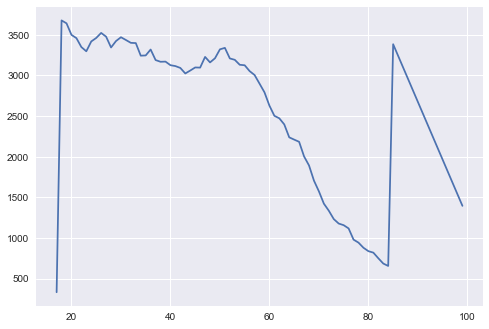

In [335]:
data['AGE'].value_counts().sort_index().plot(kind='line');

In [336]:
#All ages above 85 are regrouped in 85
#Unknowns are coded as 99
data.loc[data['AGE'].isin([96, 97, 98, 99]),'AGE'] = np.nan

#BIRTHYR is treated in the same way. Keep AGE
candidate_variables.extend(["AGE"])

In [337]:
data["AGE"].isna().sum()

1395

In [338]:
#PERWEIGHT technical variable to reweight samples 
data["PERWEIGHT"].describe()

count    179785.000000
mean       9416.623627
std        8351.204369
min           0.000000
25%        3784.611328
50%        6900.357910
75%       12644.689453
max      102133.750000
Name: PERWEIGHT, dtype: float64

In [339]:
data['SEX'].unique()

array([1, 2], dtype=int64)

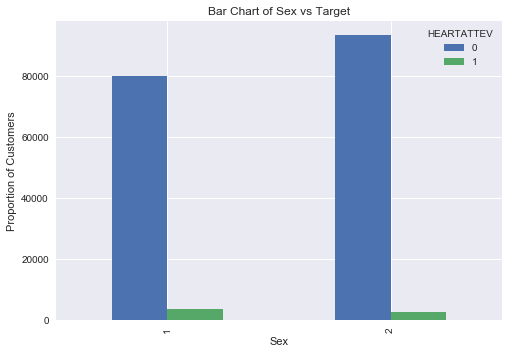

In [340]:
pd.crosstab(data.SEX,data[target_variable]).plot(kind='bar')
plt.title('Bar Chart of Sex vs Target')
plt.xlabel('Sex')
plt.ylabel('Proportion of Customers')
plt.savefig('Results\sex_vs_tgt')

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


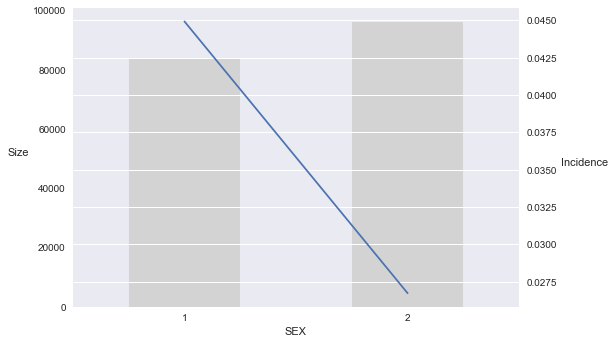

In [341]:
plot_pig_table(data, target_variable, "SEX")

In [342]:
data["SEX"].isna().sum()

0

In [343]:
candidate_variables.extend(["SEX"])

In [344]:
data['MARSTAT'] = data['MARSTAT'].astype('object')

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


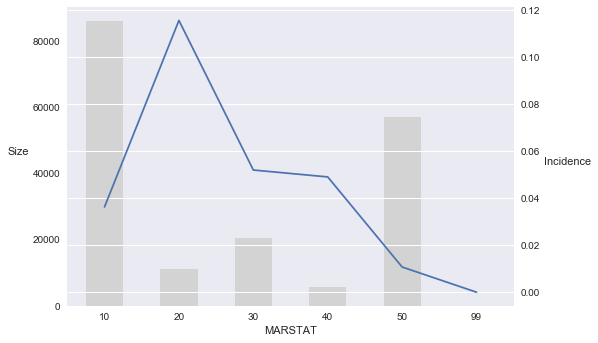

In [345]:
plot_pig_table(data, target_variable, "MARSTAT")

In [346]:
data["MARSTAT"].isna().sum()

0

In [347]:
candidate_variables.extend(["MARSTAT"])

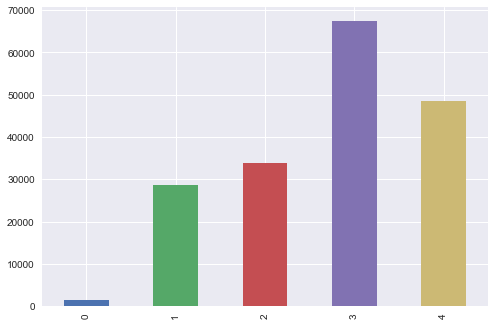

In [348]:
data['REGIONMEPS'].value_counts().sort_index().plot("bar");

In [349]:
data.loc[data['REGIONMEPS'] == 0, "REGIONMEPS"] = 99
data['REGIONMEPS'] = data['REGIONMEPS'].astype('object')

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


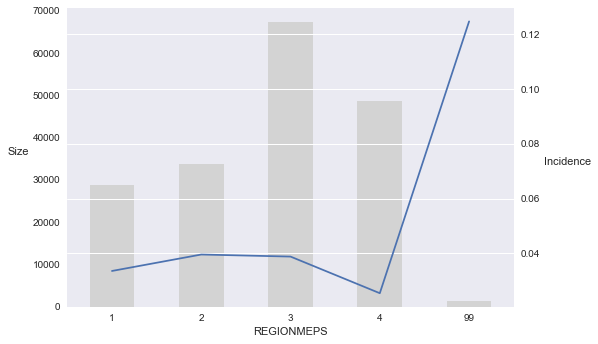

In [350]:
plot_pig_table(data, target_variable, "REGIONMEPS")

In [351]:
candidate_variables.extend(["REGIONMEPS"])

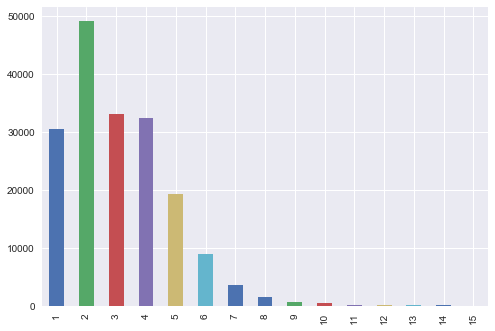

In [352]:
data['FAMSIZE'].value_counts().sort_index().plot("bar");

In [353]:
data["FAMSIZE"].isna().sum()

0

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


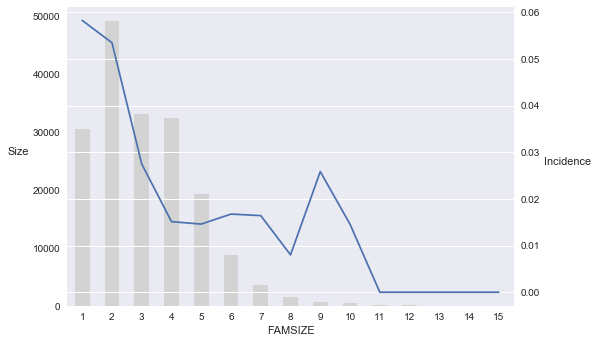

In [354]:
plot_pig_table(data, target_variable, "FAMSIZE")

In [355]:
candidate_variables.extend(["FAMSIZE"])

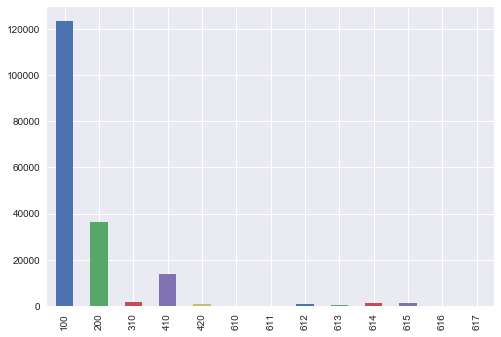

In [356]:
data['RACEA'].value_counts().sort_index().plot("bar");

In [357]:
data["RACEA"].isna().sum()

0

In [358]:
data.loc[~data['RACEA'].isin([100, 200, 310, 410, 614, 615]),'RACEA'] = 999
data['RACEA'] = data['RACEA'].astype('object')

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


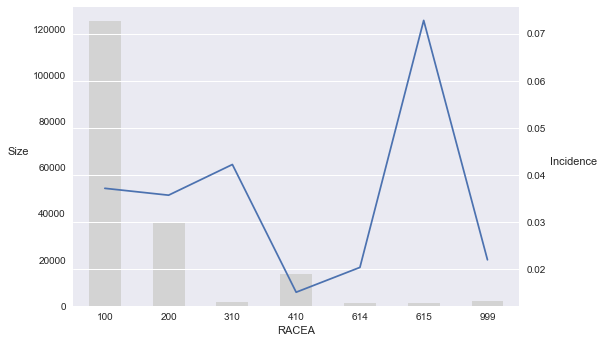

In [359]:
plot_pig_table(data, target_variable, "RACEA")

In [360]:
candidate_variables.extend(["RACEA"])

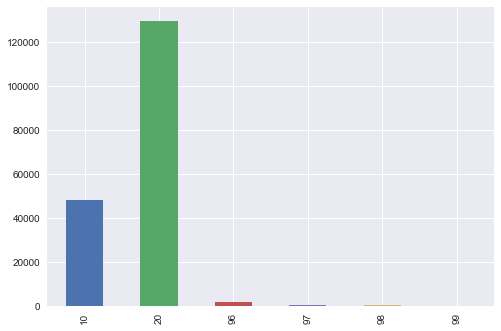

In [361]:
data['USBORN'].value_counts().sort_index().plot("bar");

In [362]:
data["USBORN"].isna().sum()

0

In [363]:
data.loc[~data['USBORN'].isin([10, 20]),'USBORN'] = 99
data['USBORN'] = data['USBORN'].astype('object')

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


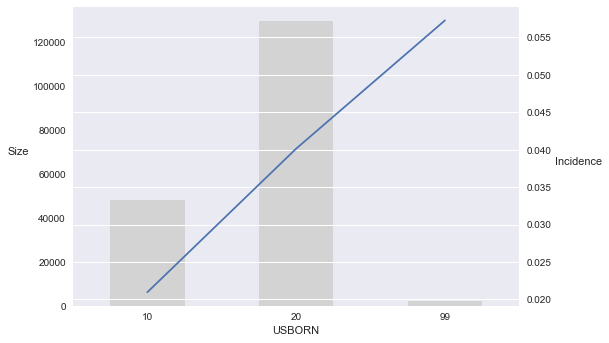

In [364]:
plot_pig_table(data, target_variable, "USBORN")

In [365]:
candidate_variables.extend(["USBORN"])

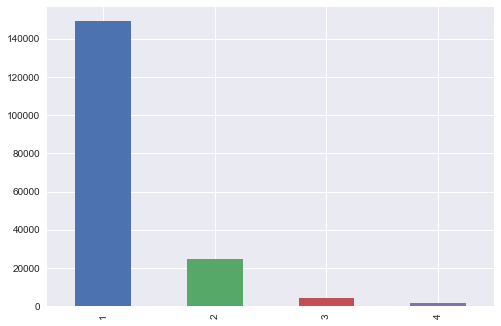

In [366]:
data['INTERVLANG'].value_counts().sort_index().plot("bar");

In [367]:
data['INTERVLANG'] = data['INTERVLANG'].astype('object')
data["INTERVLANG"].isna().sum()

0

In [368]:
data.loc[data['INTERVLANG'] == 1, 'INTERVLANG'] = "Eng"
data.loc[data['INTERVLANG'] == 2, 'INTERVLANG'] = "Sp"
data.loc[data['INTERVLANG'] == 3, 'INTERVLANG'] = "Eng_Sp"
data.loc[data['INTERVLANG'] == 4, 'INTERVLANG'] = "Unknown"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


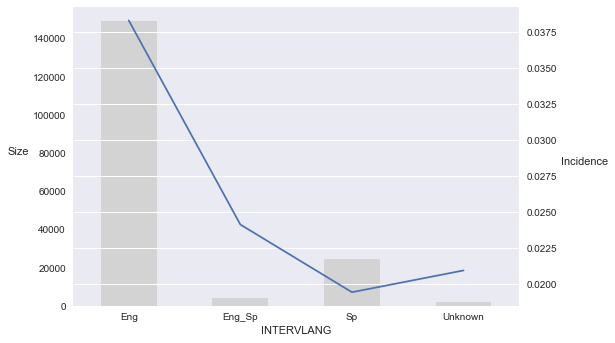

In [369]:
plot_pig_table(data, target_variable, "INTERVLANG")

In [370]:
candidate_variables.extend(["INTERVLANG"])

FILESTATUS: Status in latest tax file (Single, Married etc.)

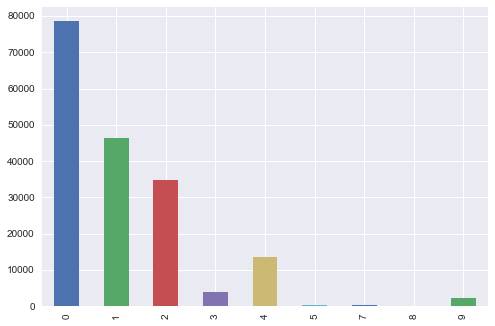

In [371]:
data['FILESTATUS'].value_counts().sort_index().plot("bar");

In [372]:
data['FILESTATUS'] = data['FILESTATUS'].astype('object')
data["FILESTATUS"].isna().sum()

0

In [373]:
data.loc[~data['FILESTATUS'].isin([1, 2, 3, 4]),'FILESTATUS'] = "Unknown"
data.loc[data['FILESTATUS'] == 1, 'FILESTATUS'] = "Single"
data.loc[data['FILESTATUS'] == 2, 'FILESTATUS'] = "Married_joint"
data.loc[data['FILESTATUS'] == 3, 'FILESTATUS'] = "Married_sep"
data.loc[data['FILESTATUS'] == 4, 'FILESTATUS'] = "Head_wq"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


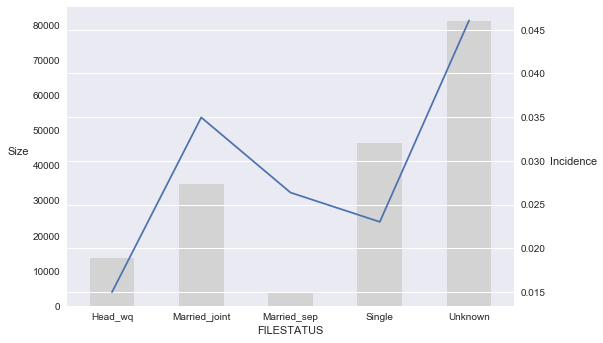

In [374]:
plot_pig_table(data, target_variable, "FILESTATUS")

In [375]:
candidate_variables.extend(["FILESTATUS"])

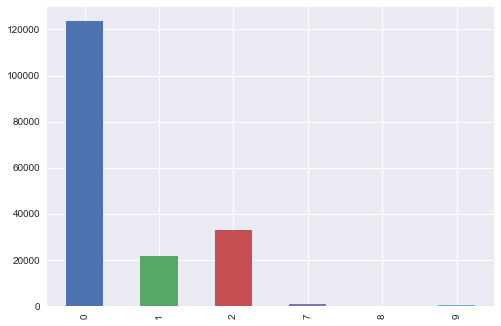

In [376]:
data['WORKEV'].value_counts().sort_index().plot("bar");

In [377]:
data['WORKEV'] = data['WORKEV'].astype('object')
data["WORKEV"].isna().sum()

0

In [378]:
data.loc[~data['WORKEV'].isin([1, 2]),'WORKEV'] = "Unknown"
data.loc[data['WORKEV'] == 1, 'WORKEV'] = "No"
data.loc[data['WORKEV'] == 2, 'WORKEV'] = "Yes"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


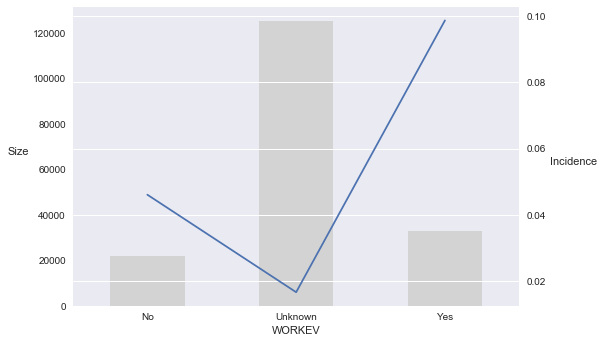

In [379]:
plot_pig_table(data, target_variable, "WORKEV")

In [380]:
# Question only asked to those who didnt indicate current employment in prior questions
candidate_variables.extend(["WORKEV"])

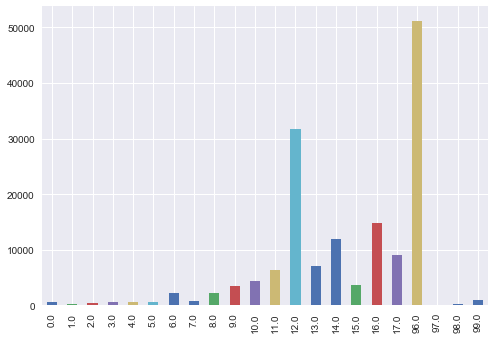

In [381]:
data['EDUCYR'].value_counts().sort_index().plot("bar");
#review if correlation high enough to just use one of two

In [382]:
data["EDUCYR"].isna().sum()

26499

In [383]:
# regroup different types of unknown. Treat variable as numeric therefore keep as missing
# integer variable canont handle empty, keep as float
data.loc[data['EDUCYR'].isin([96, 97, 98, 99]),'EDUCYR'] = np.nan

In [384]:
data["EDUCYR"].isna().sum()

79035

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


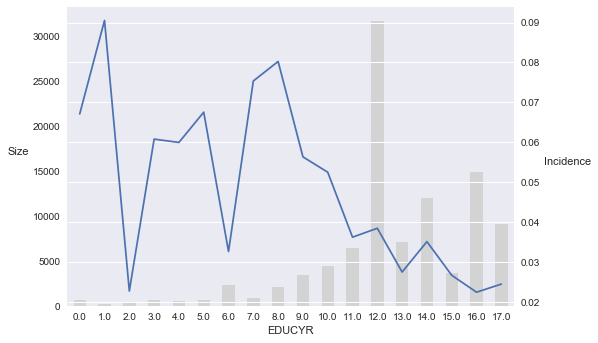

In [385]:
plot_pig_table(data, target_variable, "EDUCYR")

In [386]:
candidate_variables.extend(["EDUCYR"])

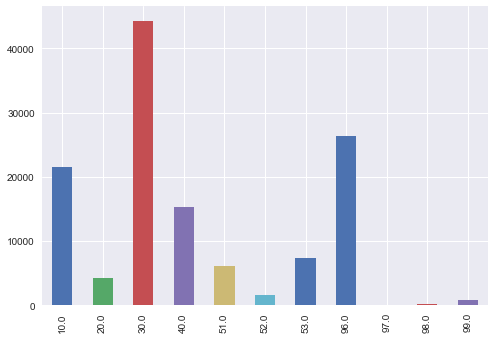

In [387]:
data['HIDEG'].value_counts().sort_index().plot("bar");

In [388]:
data["HIDEG"].isna().sum()

51560

In [389]:
# regroup different types of unknown. Treat as categorical variable, therefore replace with 99
data.loc[data['HIDEG'].isna(), 'HIDEG'] = 99
data['HIDEG'] = data['HIDEG'].astype(int)
data.loc[data['HIDEG'].isin([96, 97, 98, 99]),'HIDEG'] = 99
data['HIDEG'] = data['HIDEG'].astype('object')

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


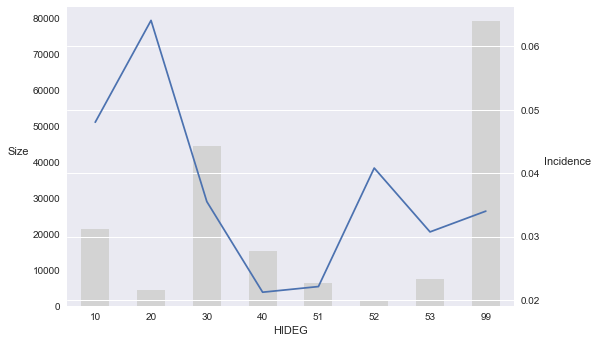

In [390]:
plot_pig_table(data, target_variable, "HIDEG")

In [391]:
data["HIDEG"].isna().sum()

0

In [392]:
candidate_variables.extend(["HIDEG"])

In [393]:
data["INCTOT"].describe()

count    179785.000000
mean      29824.530645
std       33950.942183
min     -204643.000000
25%        8088.000000
50%       20000.000000
75%       40000.000000
max      731652.960000
Name: INCTOT, dtype: float64

In [394]:
data["INCTOT"].isna().sum()

0

In [395]:
data["FTOTVAL"].describe()

count    179785.000000
mean      61156.177518
std       57114.272213
min     -258220.000000
25%       21855.000000
50%       45000.000000
75%       82930.000000
max      731653.000000
Name: FTOTVAL, dtype: float64

In [396]:
data["FTOTVAL"].isna().sum()

0

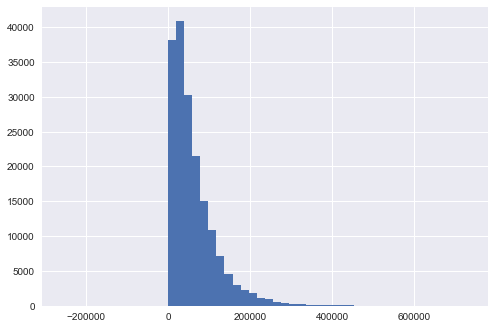

In [397]:
data["FTOTVAL"].hist(bins=50);

In [398]:
data.loc[data["FTOTVAL"]<-10000, "FTOTVAL"].size

35

In [399]:
#only few outliers with large negative total value. Limit to -10000
data.loc[data["FTOTVAL"]<-10000, "FTOTVAL"] = -10000

In [400]:
candidate_variables.extend(["FTOTVAL"])

POVLEV: Family income as a % of poverty line

In [401]:
data["POVLEV"].describe()

count    179785.000000
mean        330.748285
std         307.941344
min       -1638.979968
25%         125.650000
50%         244.040000
75%         438.660000
max        5859.789824
Name: POVLEV, dtype: float64

In [402]:
data["POVLEV"].isna().sum()

0

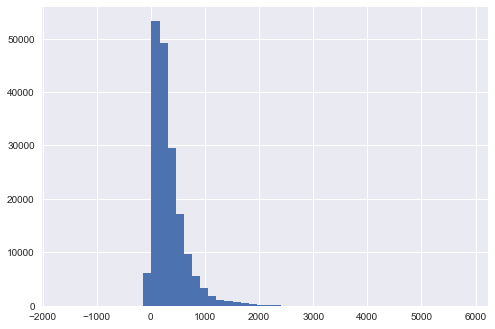

In [403]:
data["POVLEV"].hist(bins=50);

In [404]:
candidate_variables.extend(["POVLEV"])

In [405]:
data['DIABETICEV'].value_counts()

1    160998
2     18755
9        27
7         5
Name: DIABETICEV, dtype: int64

In [406]:
data.loc[data['DIABETICEV'].isin([1, 7, 9]),'DIABETICEV'] = 0
data.loc[data['DIABETICEV'] == 2,'DIABETICEV'] = 1

In [407]:
data["DIABETICEV"].isna().sum()

0

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


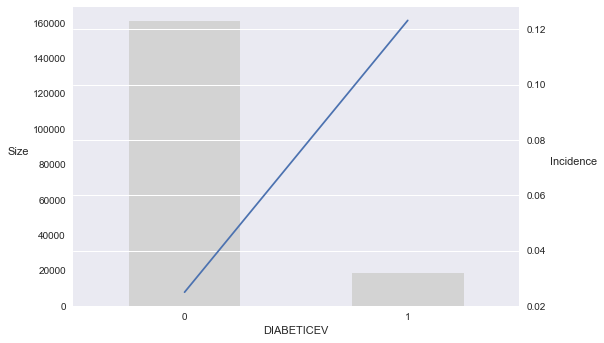

In [408]:
plot_pig_table(data, target_variable, "DIABETICEV")

In [409]:
data['DIABETICEV'] = data['DIABETICEV'].astype('int64')

In [410]:
candidate_variables.extend(["DIABETICEV"])

In [411]:
candidate_variables
#candidate_variables = ['YEAR', 'PERWEIGHT', 'SAQWEIGHT', 'AGE', 'SEX', 'MARSTAT', 'EDUCYR', 'HIDEG', 'INCTOT', 'FTOTVAL', 'DIABETICEV']

['YEAR',
 'AGE',
 'SEX',
 'MARSTAT',
 'REGIONMEPS',
 'FAMSIZE',
 'RACEA',
 'USBORN',
 'INTERVLANG',
 'FILESTATUS',
 'WORKEV',
 'EDUCYR',
 'HIDEG',
 'FTOTVAL',
 'POVLEV',
 'DIABETICEV']

In [412]:
train = data[candidate_variables]
Label = data[target_variable]

In [413]:
train.shape

(179785, 16)

In [414]:
cat_features = [train.columns[i] for i, j in enumerate(train.dtypes) if (j == "object" or j == "bool")]
numeric_features = [train.columns[i] for i, j in enumerate(train.dtypes) if j in ["int64", "float64"]]

In [415]:
cat_features

['MARSTAT',
 'REGIONMEPS',
 'RACEA',
 'USBORN',
 'INTERVLANG',
 'FILESTATUS',
 'WORKEV',
 'HIDEG']

In [416]:
numeric_features

['YEAR', 'AGE', 'SEX', 'FAMSIZE', 'EDUCYR', 'FTOTVAL', 'POVLEV', 'DIABETICEV']

In [417]:
#sns.pairplot(data[numeric_features].dropna());

# Dummy variables

In [418]:
train_cat = train[cat_features]
for var in cat_features:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train_cat[var], prefix=var)
    data1=train_cat.join(cat_list)
    train_cat=data1
train_cat.head()

,MARSTAT,REGIONMEPS,RACEA,USBORN,INTERVLANG,FILESTATUS,WORKEV,HIDEG,MARSTAT_10,MARSTAT_20,...,WORKEV_Unknown,WORKEV_Yes,HIDEG_10,HIDEG_20,HIDEG_30,HIDEG_40,HIDEG_51,HIDEG_52,HIDEG_53,HIDEG_99
0,10,1,100,10,Sp,Head_wq,Unknown,53,1,0,...,1,0,0,0,0,0,0,0,1,0
1,10,1,100,10,Sp,Unknown,Yes,30,1,0,...,0,1,0,0,1,0,0,0,0,0
2,10,4,999,10,Eng,Married_joint,Unknown,52,1,0,...,1,0,0,0,0,0,0,1,0,0
3,10,4,410,10,Eng,Unknown,Unknown,51,1,0,...,1,0,0,0,0,0,1,0,0,0
4,50,1,200,20,Eng,Unknown,Unknown,99,0,0,...,1,0,0,0,0,0,0,0,0,1


# Missing values

In [419]:
train_num = train[numeric_features]
# check variables that are missing
for j in range(train_num.values.shape[1]):
    vec = train_num.values[:,j]
    mask = np.isfinite(vec)
    if np.sum(~mask) > 0:
        print(j, train_num.columns[j])
        print(np.sum(~mask))

1 AGE
1395
4 EDUCYR
79035


In [420]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(train_num)
train_num_imp= imp.transform(train_num)

In [421]:
train_num = pd.DataFrame(train_num_imp, columns = train_num.columns)
train_num['YEAR'] = train_num['YEAR'].astype('int64')
train_num['AGE'] = train_num['AGE'].astype('int64')
train_num['SEX'] = train_num['SEX'].astype('int64')
train_num['FAMSIZE'] = train_num['FAMSIZE'].astype('int64')
train_num['DIABETICEV'] = train_num['DIABETICEV'].astype('int64')

In [422]:
train_num.dtypes

YEAR            int64
AGE             int64
SEX             int64
FAMSIZE         int64
EDUCYR        float64
FTOTVAL       float64
POVLEV        float64
DIABETICEV      int64
dtype: object

In [423]:
train_cat.head()

,MARSTAT,REGIONMEPS,RACEA,USBORN,INTERVLANG,FILESTATUS,WORKEV,HIDEG,MARSTAT_10,MARSTAT_20,...,WORKEV_Unknown,WORKEV_Yes,HIDEG_10,HIDEG_20,HIDEG_30,HIDEG_40,HIDEG_51,HIDEG_52,HIDEG_53,HIDEG_99
0,10,1,100,10,Sp,Head_wq,Unknown,53,1,0,...,1,0,0,0,0,0,0,0,1,0
1,10,1,100,10,Sp,Unknown,Yes,30,1,0,...,0,1,0,0,1,0,0,0,0,0
2,10,4,999,10,Eng,Married_joint,Unknown,52,1,0,...,1,0,0,0,0,0,0,1,0,0
3,10,4,410,10,Eng,Unknown,Unknown,51,1,0,...,1,0,0,0,0,0,1,0,0,0
4,50,1,200,20,Eng,Unknown,Unknown,99,0,0,...,1,0,0,0,0,0,0,0,0,1


In [424]:
train_cat.columns

Index(['MARSTAT', 'REGIONMEPS', 'RACEA', 'USBORN', 'INTERVLANG', 'FILESTATUS',
       'WORKEV', 'HIDEG', 'MARSTAT_10', 'MARSTAT_20', 'MARSTAT_30',
       'MARSTAT_40', 'MARSTAT_50', 'MARSTAT_99', 'REGIONMEPS_1',
       'REGIONMEPS_2', 'REGIONMEPS_3', 'REGIONMEPS_4', 'REGIONMEPS_99',
       'RACEA_100', 'RACEA_200', 'RACEA_310', 'RACEA_410', 'RACEA_614',
       'RACEA_615', 'RACEA_999', 'USBORN_10', 'USBORN_20', 'USBORN_99',
       'INTERVLANG_Eng', 'INTERVLANG_Eng_Sp', 'INTERVLANG_Sp',
       'INTERVLANG_Unknown', 'FILESTATUS_Head_wq', 'FILESTATUS_Married_joint',
       'FILESTATUS_Married_sep', 'FILESTATUS_Single', 'FILESTATUS_Unknown',
       'WORKEV_No', 'WORKEV_Unknown', 'WORKEV_Yes', 'HIDEG_10', 'HIDEG_20',
       'HIDEG_30', 'HIDEG_40', 'HIDEG_51', 'HIDEG_52', 'HIDEG_53', 'HIDEG_99'],
      dtype='object')

# Dataset

In [425]:
train = pd.concat([train_num, train_cat], axis=1, sort=True)
train = train.drop(['MARSTAT', 'HIDEG', 'REGIONMEPS', 'RACEA', 'USBORN', 'INTERVLANG', 'FILESTATUS', 'WORKEV'], axis=1)
train.shape

(179785, 49)

# Train-test

In [426]:
X_train, X_test, y_train, y_test = train_test_split(train, Label, random_state=0)

In [427]:
y_train.value_counts().sort_index()

0    130168
1      4670
Name: HEARTATTEV, dtype: int64

In [428]:
y_test.value_counts().sort_index()

0    43288
1     1659
Name: HEARTATTEV, dtype: int64

# K-fold

In [429]:
num_folds = 5
seed = 7

kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Logistic Regression - Forward selection

In [430]:
# remove one category (null)
X_train_LR = X_train.drop(['MARSTAT_99', 'HIDEG_99', 'REGIONMEPS_99', 'RACEA_999', 'USBORN_99', 'INTERVLANG_Unknown', 'FILESTATUS_Unknown', 'WORKEV_Unknown'], axis=1)
X_test_LR = X_test.drop(['MARSTAT_99', 'HIDEG_99', 'REGIONMEPS_99', 'RACEA_999', 'USBORN_99', 'INTERVLANG_Unknown', 'FILESTATUS_Unknown', 'WORKEV_Unknown'], axis=1)
basetable = pd.concat([X_train_LR, y_train], axis=1)
variables = list(X_train_LR.columns.values)

In [431]:
basetable.head()

,YEAR,AGE,SEX,FAMSIZE,EDUCYR,FTOTVAL,POVLEV,DIABETICEV,MARSTAT_10,MARSTAT_20,...,WORKEV_No,WORKEV_Yes,HIDEG_10,HIDEG_20,HIDEG_30,HIDEG_40,HIDEG_51,HIDEG_52,HIDEG_53,HEARTATTEV
87489,2013,23,1,3,12.0,1500.0,12.38,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71069,2012,23,2,2,12.0,21000.0,132.70,0,0,0,...,0,0,0,0,1,0,0,0,0,0
121339,2014,60,2,2,12.0,45488.0,286.94,0,1,0,...,0,0,0,0,0,0,0,0,0,0
43066,2011,38,1,1,13.0,26030.0,222.44,0,0,0,...,0,0,0,0,1,0,0,0,0,0
160043,2016,69,2,1,6.0,29910.0,259.84,1,0,1,...,0,1,1,0,0,0,0,0,0,0


In [432]:
max_number_variables = 8
number_iterations = min(max_number_variables, len(variables))
current_variables = []
for i in range(0,number_iterations):
    next_var = next_best(current_variables, variables, [target_variable], basetable)
    current_variables = current_variables + [next_var]
    variables.remove(next_var)
print(current_variables)

0.12927989156858594
0.1259125561457703
0.12416957628172752
0.12312071809962039
0.12194007962710385
0.12154808227957041
0.12113330023857123


C:\Users\Karsten\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.1207966399083686
['AGE', 'DIABETICEV', 'SEX', 'POVLEV', 'USBORN_10', 'WORKEV_Yes', 'WORKEV_No', 'MARSTAT_50']


In [433]:
logreg = linear_model.LogisticRegression(solver='lbfgs', max_iter = 300)

In [434]:
logreg.fit(basetable[current_variables],basetable[target_variable])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [435]:
scores = cross_val_score(logreg, basetable[current_variables],basetable[target_variable], cv=5, scoring='neg_log_loss')
-scores

array([0.1213323 , 0.12153341, 0.12072133, 0.12018264, 0.12060697])

In [436]:
y_pred_train = logreg.predict_proba(X_train_LR[current_variables])
y_pred_test = logreg.predict_proba(X_test_LR[current_variables])
print("Train AUC: ", roc_auc_score(y_train, y_pred_train[:,1]))
print("Train logloss: ", log_loss(y_train, y_pred_train[:,1]))
print("Test AUC: ", roc_auc_score(y_test, y_pred_test[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred_test[:,1]))

Train AUC:  0.8526952354243049
Train logloss:  0.1207966399083686
Test AUC:  0.8544459614949522
Test logloss:  0.12628861011877446


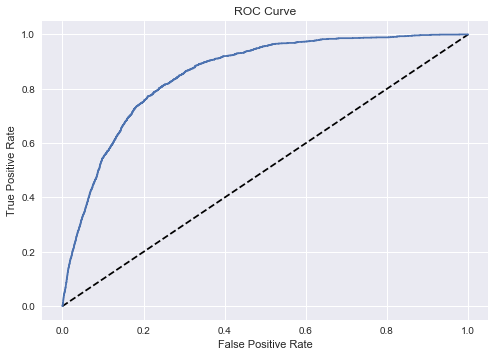

In [437]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [438]:
np.exp(logreg.coef_)

array([[1.04973277, 2.63782462, 0.454059  , 0.99912713, 0.49932071,
        1.85777001, 1.85523628, 0.60894681]])

In [439]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,basetable[current_variables])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.134073
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.109     
Dependent Variable: HEARTATTEV       AIC:              36172.1409
Date:               2018-12-08 17:18 BIC:              36250.6355
No. Observations:   134838           Log-Likelihood:   -18078.   
Df Model:           7                LL-Null:          -20293.   
Df Residuals:       134830           LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
AGE          -0.0003    0.0008   -0.3250  0.7451  -0.0019   0.0013
DIABETICEV    1.0099    0.0345   29.2868  0.0000   0.9424   1.

In [440]:
conf_matrix = confusion_matrix(y_test, logreg.predict(X_test[current_variables]))
print(conf_matrix)

[[43282     6]
 [ 1658     1]]


# Logistic Regression - Grid search

In [441]:
c_space = np.logspace(-5, 2, 10)

param_grid_logreg_bk = {
    'C': c_space,
    'penalty': ["l1"]
}
    
param_grid_logreg = {
    'C': [0.5],
    'penalty': ["l1"]
}

In [442]:
logreg2 = linear_model.LogisticRegression(solver='liblinear') #'lbfgs')
grid_logreg = GridSearchCV(logreg2, param_grid_logreg, cv=kfold, scoring='neg_log_loss', error_score='raise')
grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.5], 'penalty': ['l1']}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

In [443]:
means = -grid_logreg.cv_results_['mean_test_score']
stds = grid_logreg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_logreg.cv_results_['params']):
   print("%0.4f (+/-%0.05f) for %r"
   % (mean, std * 2, params))

0.1188 (+/-0.00119) for {'C': 0.5, 'penalty': 'l1'}


In [444]:
logreg = grid_logreg.best_estimator_
logreg

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

best parameters: {'C': 0.5, 'penalty': 'l1'}
best score:      0.11883 (+/-0.00060)


C:\Users\Karsten\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Karsten\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Karsten\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Karsten\Anaconda3\lib\site-packages\skle

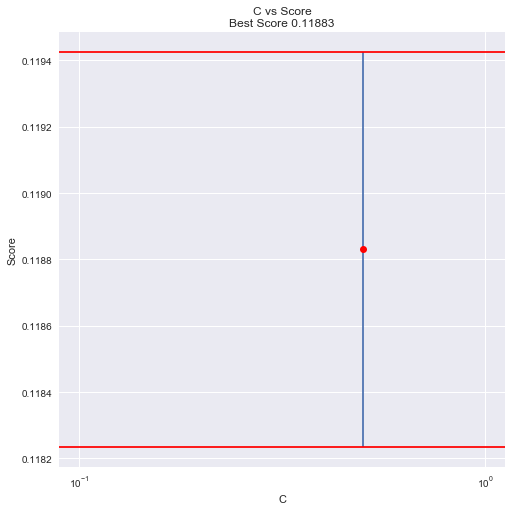

In [445]:
param_name = 'C'
logreg_params = grid_logreg.best_params_
logreg_score = -grid_logreg.best_score_
logreg_stdev = grid_logreg.cv_results_['std_test_score'][grid_logreg.best_index_]
cv_results = grid_logreg.cv_results_

print("best parameters: {}".format(logreg_params))
print("best score:      {:0.5f} (+/-{:0.5f})".format(logreg_score, logreg_stdev))

# pick out the best results
# =========================
scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

best_row = scores_df.iloc[0, :]
best_mean = -best_row['mean_test_score']
best_stdev = best_row['std_test_score']
best_param = best_row['param_' + param_name]

# display the top 'num_results' results
# =====================================
#display(pd.DataFrame(cv_results).sort_values(by='rank_test_score').head(5))

# plot the results
# ================
scores_df = scores_df.sort_values(by='param_' + param_name)

means = -scores_df['mean_test_score']
stds = scores_df['std_test_score']
params = scores_df['param_' + param_name]

# plot
plt.figure(figsize=(8, 8))
plt.errorbar(params, means, yerr=stds)

plt.axhline(y=best_mean + best_stdev, color='red')
plt.axhline(y=best_mean - best_stdev, color='red')
plt.xscale('log')
plt.plot(best_param, best_mean, 'or')

plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(logreg_score))
plt.xlabel(param_name)
plt.ylabel('Score')
plt.show()

In [446]:
y_pred_train = grid_logreg.predict_proba(X_train)
y_pred_test = grid_logreg.predict_proba(X_test)
print("Train AUC: ", roc_auc_score(y_train, y_pred_train[:,1]))
print("Train logloss: ", log_loss(y_train, y_pred_train[:,1]))
print("Train Brier Score: ", brier_score_loss(y_train, y_pred_train[:,1], pos_label=1))

print("Test AUC: ", roc_auc_score(y_test, y_pred_test[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred_test[:,1]))
print("Test Brier Score: ", brier_score_loss(y_test, y_pred_test[:,1], pos_label=1))

Train AUC:  0.8614422547596866
Train logloss:  0.11849901226722913
Train Brier Score:  0.030532532564618013
Test AUC:  0.8592125978725943
Test logloss:  0.12486212166421815
Test Brier Score:  0.03246548280762365


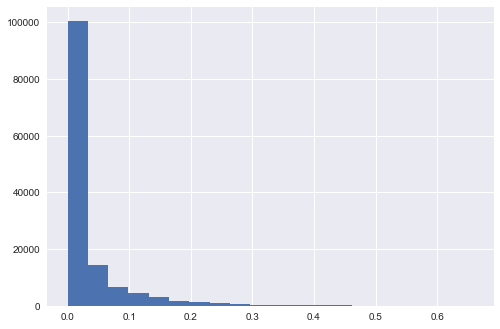

In [447]:
plt.hist(y_pred_train[:,1], bins=20);

In [448]:
fop, mpv = calibration_curve(y_test, y_pred_test[:,1], n_bins=10)

In [449]:
I = pd.Index(["LogReg_true", "LogReg_pred"])
calib_curves = pd.DataFrame([fop, mpv], index = I)
calib_curves

,0,1,2,3,4,5,6
LogReg_true,0.020895,0.158344,0.221174,0.279570,0.303571,0.333333,0.000000
LogReg_pred,0.018277,0.139375,0.242395,0.338769,0.442197,0.540451,0.614524


In [450]:
def bin_total(y_true, y_prob, n_bins):
    bins = np. linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    return np.bincount(binids, minlength=len(bins))
bin_total(y_test, y_pred_test[:,1], n_bins=10)

array([40536,  3044,   954,   279,   112,    21,     1,     0,     0,
           0,     0], dtype=int64)

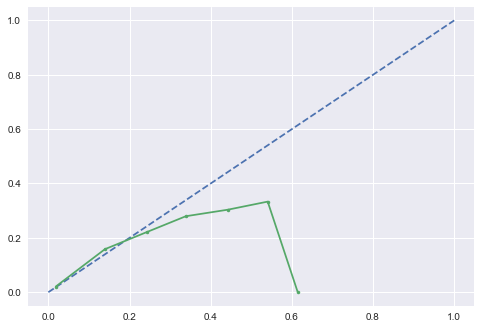

In [451]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

In [452]:
coeff = pd.DataFrame({'feature': X_train.columns, 'coef': np.exp(grid_logreg.best_estimator_.coef_.flatten())})
coeff.to_excel("Results/LogReg_coeff.xls", index = True)

In [453]:
results = pd.DataFrame({'true': y_test, 'predictions': y_pred_test[:,1]})
results = pd.concat([X_test, results], axis=1)
#results.to_excel("Results/out_LogReg.xls", index = True)

In [454]:
results.shape

(44947, 51)

# XGBoost

In [455]:
param_grid_xgb = {
    'max_depth': [5],
    'min_child_weight': [10],
    'n_estimators': [100],
    'learning_rate': [0.1],
    'gamma': [0],
    'subsample': [1],
    'colsample_bytree': [1]
    }

In [456]:
m_XGB = xgb.XGBClassifier()
grid_XGB = GridSearchCV(m_XGB, param_grid_xgb, cv=kfold, scoring='neg_log_loss')
grid_XGB.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5], 'min_child_weight': [10], 'n_estimators': [100], 'learning_rate': [0.1], 'gamma': [0], 'subsample': [1], 'colsample_bytree': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [457]:
grid_XGB.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [458]:
means = -grid_XGB.cv_results_['mean_test_score']
stds = -grid_XGB.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_XGB.cv_results_['params']):
   print("%0.4f (+/-%0.04f) for %r"
   % (mean, std * 2, params))

0.1161 (+/--0.0003) for {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 1}


In [459]:
y_pred = grid_XGB.predict_proba(X_test)

print("Test AUC: ", roc_auc_score(y_test, y_pred[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred[:,1]))
print("Test Brier Score: ", brier_score_loss(y_test, y_pred[:,1], pos_label=1))

Test AUC:  0.8678265335642829
Test logloss:  0.12204127429398678
Test Brier Score:  0.03210811552452948


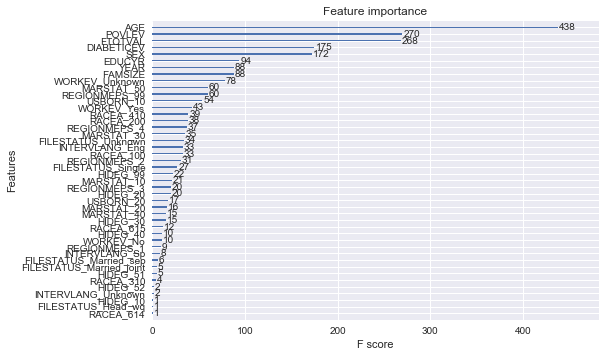

In [460]:
xgb.plot_importance(grid_XGB.best_estimator_);

In [461]:
conf_matrix = confusion_matrix(y_test, grid_XGB.best_estimator_.predict(X_test))
print(conf_matrix)

[[43285     3]
 [ 1657     2]]


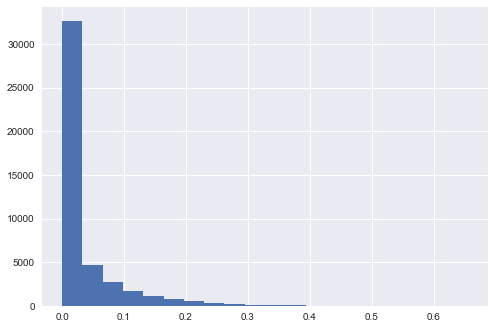

In [462]:
plt.hist(y_pred[:,1], bins=20);

In [463]:
fop, mpv = calibration_curve(y_test, y_pred[:,1], n_bins=10)
bin_total(y_test, y_pred[:,1], n_bins=10)

array([40125,  3501,  1033,   239,    44,     4,     1,     0,     0,
           0,     0], dtype=int64)

In [464]:
calib_curves = calib_curves.append(pd.Series(fop, name="XGBoost_true"))
calib_curves = calib_curves.append(pd.Series(mpv, name="XGBoost_pred"))
calib_curves

,0,1,2,3,4,5,6
LogReg_true,0.020895,0.158344,0.221174,0.279570,0.303571,0.333333,0.000000
LogReg_pred,0.018277,0.139375,0.242395,0.338769,0.442197,0.540451,0.614524
XGBoost_true,0.019364,0.155099,0.235237,0.322176,0.386364,0.500000,0.000000
XGBoost_pred,0.017779,0.140378,0.236463,0.338438,0.433045,0.523111,0.654786


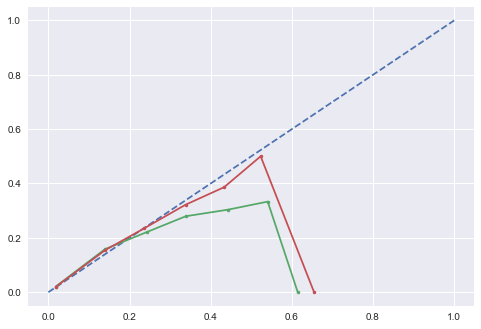

In [465]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( calib_curves.loc["LogReg_pred"], calib_curves.loc["LogReg_true"], marker='.')
plt.plot( calib_curves.loc["XGBoost_pred"], calib_curves.loc["XGBoost_true"], marker='.')
plt.show()

In [466]:
results = pd.DataFrame({'true': y_test, 'predictions': y_pred[:,1]})
results = pd.concat([X_test, results], axis=1)
#results.to_excel("Results/out_XGB.xls", index = True)

# GBM

In [467]:
param_grid_gbm = {
    'max_depth': [6],
    'min_samples_leaf': [20],
    'n_estimators': [100],
    'learning_rate': [0.1],
    'subsample': [1],
    }

param_grid_gbm_bk = {
    'max_depth': [6],
    'min_samples_leaf': [20],
    'n_estimators': [100],
    'learning_rate': [0.1],
    'subsample': [1],
    }

In [468]:
m_GBM = GradientBoostingClassifier()
grid_GBM = GridSearchCV(m_GBM, param_grid_gbm, cv=kfold, scoring='neg_log_loss', n_jobs = 3)
grid_GBM.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_depth': [6], 'min_samples_leaf': [20], 'n_estimators': [100], 'learning_rate': [0.1], 'subsample': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [469]:
grid_GBM.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [470]:
means = -grid_GBM.cv_results_['mean_test_score']
stds = grid_GBM.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_GBM.cv_results_['params']):
   print("%0.4f (+/-%0.04f) for %r"
   % (mean, std * 2, params))

0.1163 (+/-0.0007) for {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 20, 'n_estimators': 100, 'subsample': 1}


In [471]:
y_pred = grid_GBM.predict_proba(X_test)
print("Test AUC: ", roc_auc_score(y_test, y_pred[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred[:,1]))
print("Test Brier Score: ", brier_score_loss(y_test, y_pred[:,1], pos_label=1))

Test AUC:  0.8688619191433431
Test logloss:  0.12191328840998232
Test Brier Score:  0.03205015471149282


In [472]:
fop, mpv = calibration_curve(y_test, y_pred[:,1], n_bins=10)
bin_total(y_test, y_pred[:,1], n_bins=10)

array([40368,  3110,  1006,   330,    93,    30,     8,     2,     0,
           0,     0], dtype=int64)

In [473]:
calib_curves = calib_curves.append(pd.Series(fop, name="GBM_true"))
calib_curves = calib_curves.append(pd.Series(mpv, name="GBM_pred"))
calib_curves

,0,1,2,3,4,5,6,7
LogReg_true,0.020895,0.158344,0.221174,0.279570,0.303571,0.333333,0.000000,NaN
LogReg_pred,0.018277,0.139375,0.242395,0.338769,0.442197,0.540451,0.614524,NaN
XGBoost_true,0.019364,0.155099,0.235237,0.322176,0.386364,0.500000,0.000000,NaN
XGBoost_pred,0.017779,0.140378,0.236463,0.338438,0.433045,0.523111,0.654786,NaN
GBM_true,0.020090,0.151125,0.232604,0.272727,0.397849,0.533333,0.125000,0.000000
GBM_pred,0.017048,0.140289,0.239690,0.341964,0.440530,0.545914,0.643621,0.717087


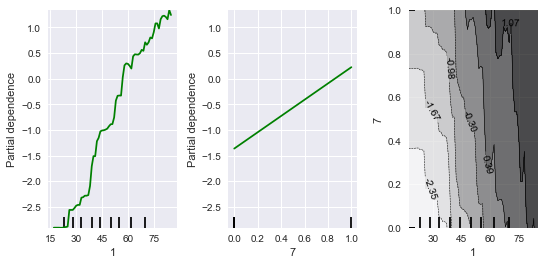

In [490]:
my_plots = plot_partial_dependence(grid_GBM.best_estimator_, features=[1, 7, (1,7)], X=X_train)

In [475]:
partial_dependence(grid_GBM.best_estimator_, X=X_train, target_variables=[7])

(array([[-1.36367317,  0.22414336]]), [array([0., 1.], dtype=float32)])

In [476]:
X_train['DIABETICEV'].dtype

dtype('int64')

# Random Forest

In [477]:
param_grid_RF = {
    'max_depth': [12],
    'min_samples_leaf': [10],
    'max_features': ['auto'],
    'n_estimators': [300],
    }

In [478]:
RandForest = RandomForestClassifier(n_jobs=-1)
grid_RF = GridSearchCV(RandForest, param_grid_RF, cv=kfold, scoring='neg_log_loss')
grid_RF.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [12], 'min_samples_leaf': [10], 'max_features': ['auto'], 'n_estimators': [300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [479]:
grid_RF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [480]:
means = -grid_RF.cv_results_['mean_test_score']
stds = grid_RF.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_RF.cv_results_['params']):
   print("%0.4f (+/-%0.04f) for %r"
   % (mean, std * 2, params))

0.1160 (+/-0.0003) for {'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 300}


In [481]:
y_pred = grid_RF.predict_proba(X_test)

print("Test AUC: ", roc_auc_score(y_test, y_pred[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred[:,1]))
print("Test Brier Score: ", brier_score_loss(y_test, y_pred[:,1], pos_label=1))

Test AUC:  0.870246842739585
Test logloss:  0.12179684069995782
Test Brier Score:  0.03195964991907412


In [482]:
fop, mpv = calibration_curve(y_test, y_pred[:,1], n_bins=10)
bin_total(y_test, y_pred[:,1], n_bins=10)

array([40127,  4081,   706,    33,     0,     0,     0,     0,     0,
           0,     0], dtype=int64)

In [483]:
calib_curves = calib_curves.append(pd.Series(fop, name="RF_true"))
calib_curves = calib_curves.append(pd.Series(mpv, name="RF_pred"))
calib_curves

,0,1,2,3,4,5,6,7
LogReg_true,0.020895,0.158344,0.221174,0.279570,0.303571,0.333333,0.000000,NaN
LogReg_pred,0.018277,0.139375,0.242395,0.338769,0.442197,0.540451,0.614524,NaN
XGBoost_true,0.019364,0.155099,0.235237,0.322176,0.386364,0.500000,0.000000,NaN
XGBoost_pred,0.017779,0.140378,0.236463,0.338438,0.433045,0.523111,0.654786,NaN
GBM_true,0.020090,0.151125,0.232604,0.272727,0.397849,0.533333,0.125000,0.000000
GBM_pred,0.017048,0.140289,0.239690,0.341964,0.440530,0.545914,0.643621,0.717087
RF_true,0.018840,0.166871,0.287535,0.575758,NaN,NaN,NaN,NaN
RF_pred,0.020278,0.139310,0.234981,0.315701,NaN,NaN,NaN,NaN


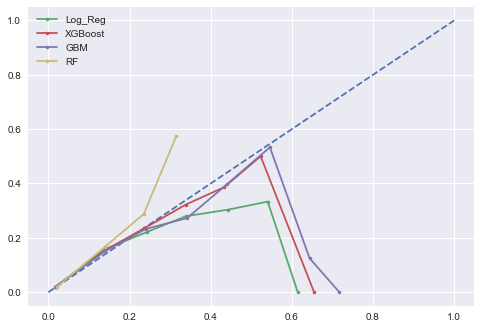

In [484]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( calib_curves.loc["LogReg_pred"], calib_curves.loc["LogReg_true"], marker='.', label="Log_Reg")
plt.plot( calib_curves.loc["XGBoost_pred"], calib_curves.loc["XGBoost_true"], marker='.', label="XGBoost")
plt.plot( calib_curves.loc["GBM_pred"], calib_curves.loc["GBM_true"], marker='.', label="GBM")
plt.plot( calib_curves.loc["RF_pred"], calib_curves.loc["RF_true"], marker='.', label="RF")
plt.legend()
plt.show()